In [1]:
%matplotlib inline

In [2]:
import pandas as pd 
import numpy as np 
from sklearn import linear_model
import statsmodels.api as sm
execfile('toolbox.py')

In [7]:
variables = ["investments_WB", "GDP_PC_PWT", "K_over_PIB", 
             "years_schooling", "openness_WB", "savings_OECD"]

data = pd.read_csv("data_source/all_data.csv", usecols=variables + ['code', 'year'], index_col=['code', 'year'])

data.reset_index(inplace=True)
data.sort_values(['code', 'year'], inplace=True)
data.set_index(['code'], inplace=True)
new_frame = pd.DataFrame()
for country in set(data.index.values):
    sel = data.loc[country]
    if sel.shape != (len(variables) + 1,):
        try:
            sel.loc[:, 'years_schooling'] = sel['years_schooling'].interpolate()
        except TypeError:
            None
        new_frame = pd.concat([new_frame, sel])
data = new_frame.reset_index().set_index(['code', 'year']).sort_index(level=[0,1])

data['shock'] = 0
data.loc[(['DEU', 'FRA', 'USA', 'GBR', 'CAN', 'JPN', 'ITA', 'AUS'], 1974), 'shock'] = 1
data.loc[(['DEU', 'FRA', 'USA', 'GBR', 'CAN', 'JPN', 'ITA', 'AUS'], 1981), 'shock'] = 1
data.loc[(['DEU', 'FRA', 'USA', 'GBR', 'CAN', 'JPN', 'ITA', 'AUS'], 1982), 'shock'] = 1
data.loc[(['DEU', 'FRA', 'USA', 'GBR', 'CAN', 'JPN', 'ITA', 'AUS'], 2008), 'shock'] = 1
data.loc[(['DEU', 'FRA', 'USA', 'GBR', 'CAN', 'JPN', 'ITA', 'AUS'], 2009), 'shock'] = 1

data['catch-up'] = (data['GDP_PC_PWT'].max() - data['GDP_PC_PWT'])
data['growth'] = growth(data, 'GDP_PC_PWT', how="past", as_rate=True)
data['GDP_PC_PWT'] = data['GDP_PC_PWT'].apply(np.log)

data = data.query("code in ['DEU', 'FRA', 'USA', 'GBR', 'CAN', 'JPN', 'ITA', 'AUS']").dropna(how='any')
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 327 entries, (AUS, 1970.0) to (USA, 2011.0)
Data columns (total 9 columns):
investments_WB     327 non-null float64
K_over_PIB         327 non-null float64
GDP_PC_PWT         327 non-null float64
years_schooling    327 non-null float64
openness_WB        327 non-null float64
savings_OECD       327 non-null float64
shock              327 non-null int64
catch-up           327 non-null float64
growth             327 non-null float64
dtypes: float64(8), int64(1)
memory usage: 25.5+ KB


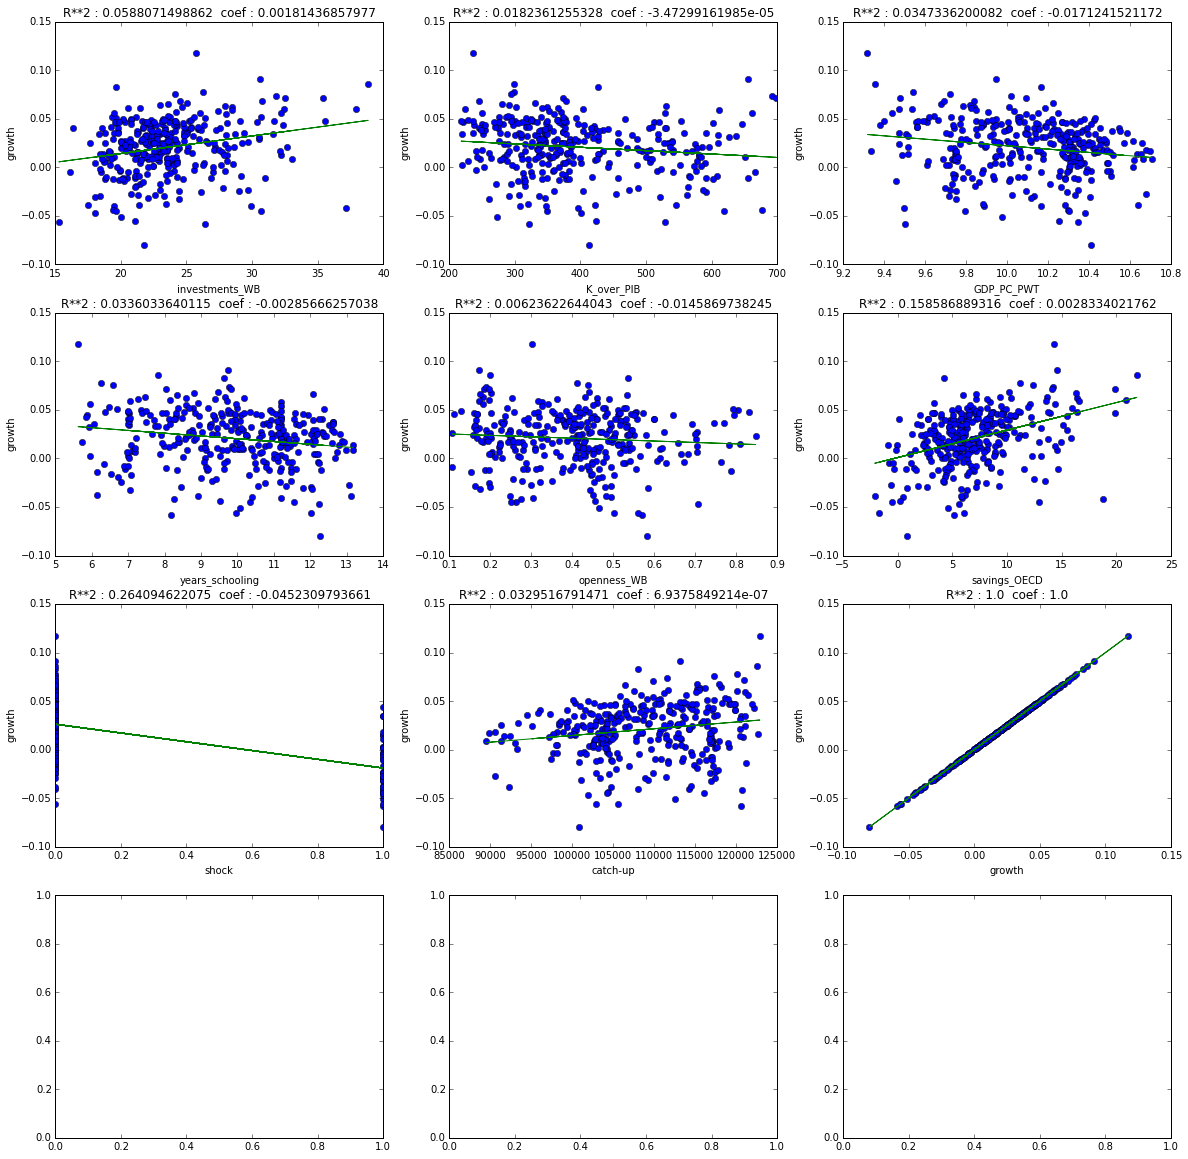

In [8]:
nbr_cols = 3
f, axarr = plt.subplots((len(data.keys()) / nbr_cols)+1, nbr_cols, figsize=(20,20))
for n, var in enumerate(data.keys()):
    i,j = n/nbr_cols, n%nbr_cols
    clf = linear_model.LinearRegression()
    clf.fit(data[[var]], data['growth'])
    axarr[i, j].plot(data[var], data['growth'], 'o')
    axarr[i, j].plot(data[var], clf.predict(data[[var]]))
    axarr[i, j].set_xlabel(var)
    axarr[i, j].set_ylabel('growth')
    axarr[i, j].set_title("R**2 : " + str(clf.score(data[[var]], data['growth'])) + "  coef : " + str(clf.coef_[0]))

## Coefficients

In [9]:
data_norm = ((data - data.mean(axis=0)) / data.std(axis=0)).sort_index(level=1)

X_sm = sm.add_constant(data_norm[variables + ["catch-up", "shock"]])
model = sm.OLS(data_norm["growth"], X_sm)
all_results = model.fit()
print(all_results.summary())

                            OLS Regression Results                            
Dep. Variable:                 growth   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     27.57
Date:                Wed, 13 Apr 2016   Prob (F-statistic):           2.05e-32
Time:                        14:36:21   Log-Likelihood:                -377.35
No. Observations:                 327   AIC:                             772.7
Df Residuals:                     318   BIC:                             806.8
Df Model:                           8                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
const            4.181e-16      0.043   9.72e-15      1.000        -0.085     0.085
investments_WB     -0.0413      0.082

## Graph

0.687488926288


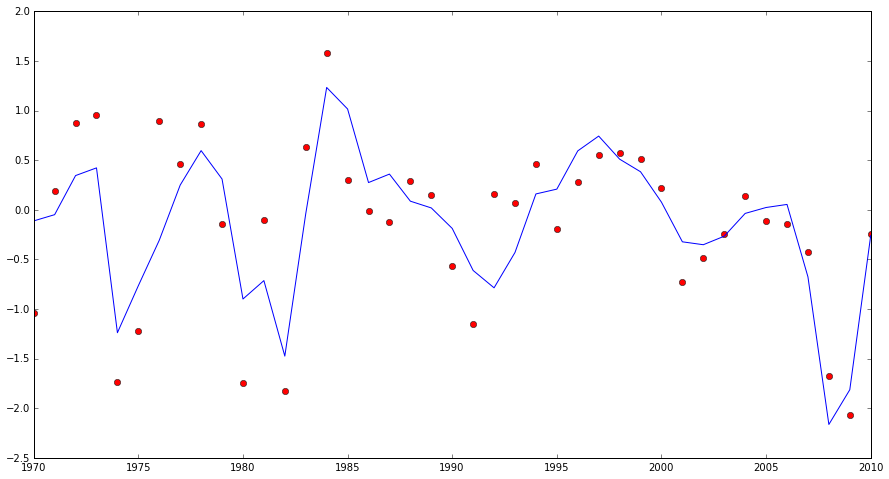

In [23]:
plt.figure(figsize=(15,8))
clf = linear_model.LinearRegression()
country = 'USA'
sel = data_norm.loc[country]
x = np.linspace(1, 100, len(sel))
clf.fit(sel[variables + ["catch-up", "shock"]], sel['growth'])
plt.plot(sel.index, sel['growth'], 'ro')
plt.plot(sel.index, clf.predict(sel[variables + ["catch-up", "shock"]]))
print clf.score(sel[variables + ["catch-up", "shock"]], sel['growth'])

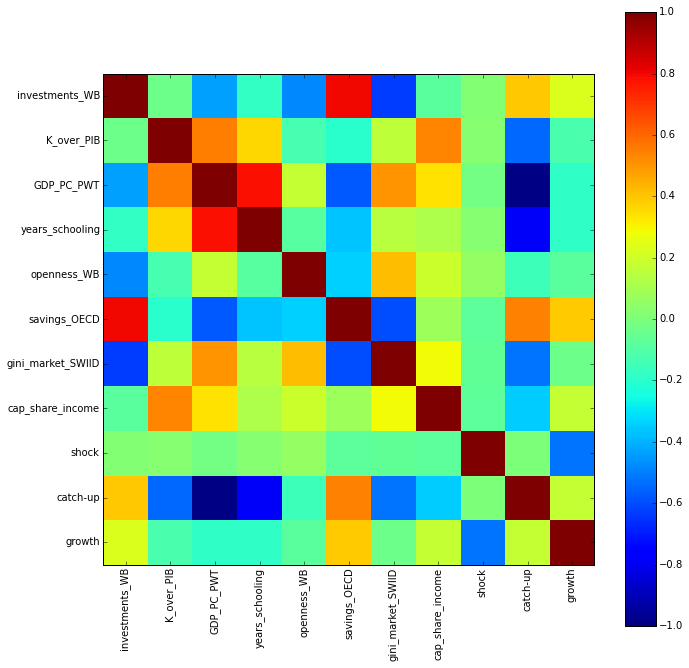

In [32]:
plot_correlations(data, size_tuple=(11,11))

R**2 =  0.917534297941
Coefficient =  0.110211810573


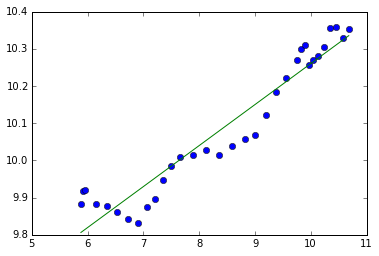

In [57]:
country = 'FRA'
clf = linear_model.LinearRegression()
clf.fit(data.loc[country][['years_schooling']], data.loc[country]["GDP_PC_PWT"])
plt.plot(data.loc[country]['years_schooling'], data.loc[country]["GDP_PC_PWT"], 'o')
plt.plot(data.loc[country]['years_schooling'], clf.predict(data.loc[country][['years_schooling']]))
print "R**2 = ", clf.score(data.loc[country][['years_schooling']], data.loc[country]["GDP_PC_PWT"])
print "Coefficient = ", clf.coef_[0]

R**2 =  8.03469587818e-06
Coefficient =  0.00131861211912


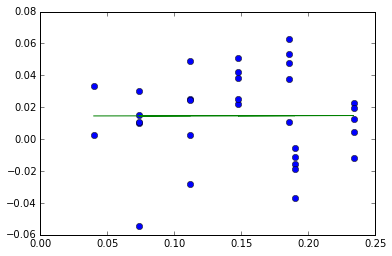

In [59]:
grow = pd.DataFrame()
grow['yrs_schl'] = growth(data, 'years_schooling')
grow['growth'] = growth(data, 'GDP_PC_PWT')
grow = grow.dropna()
country = 'FRA'
clf = linear_model.LinearRegression()
clf.fit(grow.loc[country][['yrs_schl']], grow.loc[country]["growth"])
plt.plot(grow.loc[country]['yrs_schl'], grow.loc[country]["growth"], 'o')
plt.plot(grow.loc[country]['yrs_schl'], clf.predict(grow.loc[country][['yrs_schl']]))
print "R**2 = ", clf.score(grow.loc[country][['yrs_schl']], grow.loc[country]["growth"])
print "Coefficient = ", clf.coef_[0]

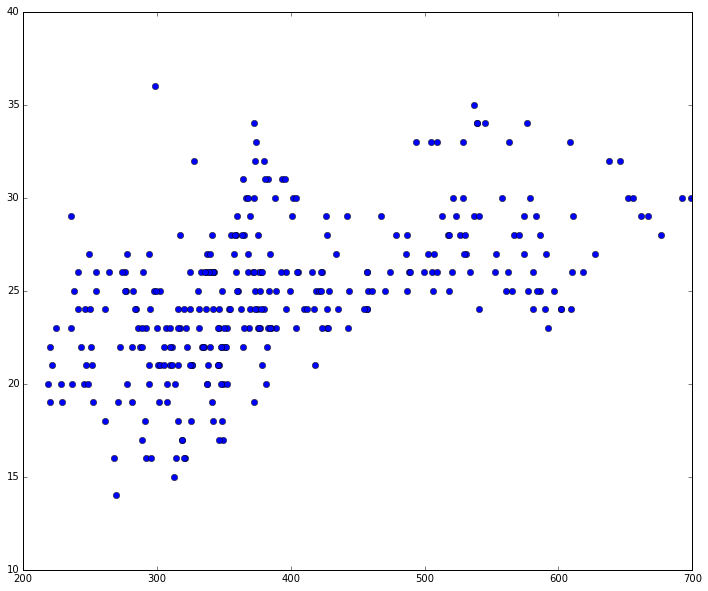

In [68]:
plt.figure(figsize=(12,10))
plt.plot(data['K_over_PIB'], data['cap_share_income'], 'o')